In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy
import pandas as pd
import cmocean as cmo
from cartopy.util import add_cyclic_point
import seaborn as sns

## Load multiple 2xCO2 datasets from longrunMIP
- prep anomalies for each of the datasets
- need SST anomaly and 
- straight up sea ice

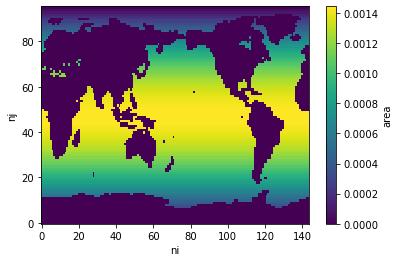

In [2]:
# tarea = xr.open_dataset('/home/disk/atmos/vcooper/work/ref/' + 'cicefsdww3i.cice.h1.0086.nc').tarea
landfrac = xr.open_dataset('/home/disk/atmos/vcooper/work/ref/' + 'domain.lnd.fv1.9x2.5_gx1v6.090206.nc')

oceanarea = landfrac.area * (1-landfrac.mask.values)
oceanarea.plot()
oceanarea = oceanarea.values

In [3]:
## set commonyear starting point
comyr = 500

In [4]:
## load CESM104 data

## annual mean SST
nyears = 200
# tslice = slice(2300,2300+nyears)
tslice = slice(comyr,comyr+nyears)
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/cesm104/'
fname = 'tos_ann_CESM104_abrupt2x_2500.nc'
cesm2x_sst = xr.open_dataset(
    lrmpath + fname, decode_times=False).isel(time=tslice).mean(dim='time')

fname = 'tos_ann_CESM104_control_1000.nc'
# tslice = slice(800,800+nyears)
tslice = slice(comyr,comyr+nyears)
cesmctrl_sst = xr.open_dataset(
    lrmpath + fname, decode_times=False).isel(time=tslice).mean(dim='time')

In [5]:
%%time
## sea ice monthly
fname = 'sic_mon_CESM104_abrupt2x_2500.nc'
cesm2x_sic = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[-12*nyears:]
montharr = np.tile(np.arange(1,12+1,1),len(cesm2x_sic)//12)
cesm2x_sic = cesm2x_sic.assign_coords(
    month=('time',montharr)).groupby('month').mean()

# fname = 'sic_mon_CESM104_control_1000.nc'
# cesmctrl_sic = xr.open_dataset(
#     lrmpath + fname, decode_times=False).sic[-12*nyears:]
# montharr = np.tile(np.arange(1,12+1,1),len(cesmctrl_sic)//12)
# cesmctrl_sic = cesmctrl_sic.assign_coords(
#     month=('time',montharr)).groupby('month').mean()

CPU times: user 13.7 s, sys: 522 ms, total: 14.2 s
Wall time: 15.7 s


In [6]:
## Regrid the longrunmip data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = cesm2x_sst
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.tos),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

cesm2x_sst_regrid = regridder(cesm2x_sst)
cesmctrl_sst_regrid = regridder(cesmctrl_sst)

## REGRID SEA ICE?
# cesmctrl_sic_regrid = regridder(cesmctrl_sic)
# cesm2x_sic_regrid = regridder(cesm2x_sic)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


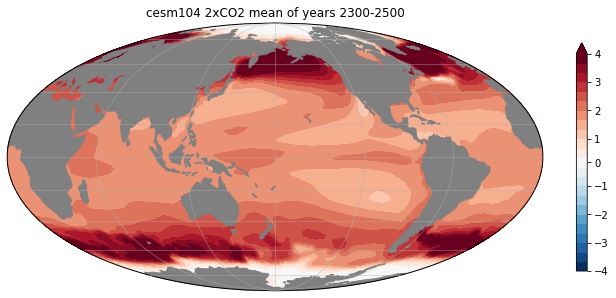

In [122]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cesm2x_sst_regrid.tos - cesmctrl_sst_regrid.tos #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('cesm104 2xCO2 mean of years 2300-2500')
plt.show()

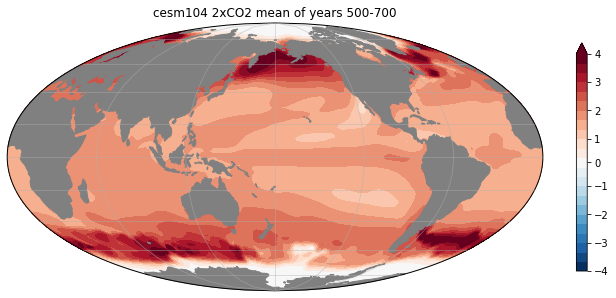

In [8]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cesm2x_sst_regrid.tos - cesmctrl_sst_regrid.tos #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('cesm104 2xCO2 mean of years 500-700')
plt.show()

In [123]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  2.08


In [9]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  1.81


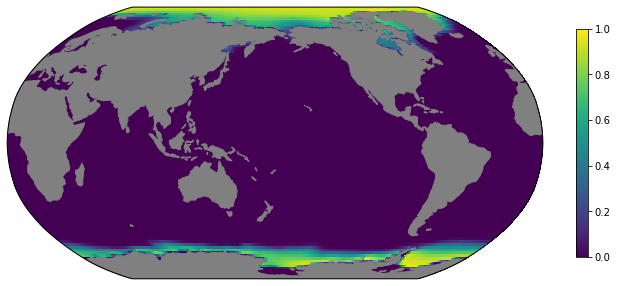

In [8]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cesm2x_sic.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title(dsname + " Holo + ecs2x")
plt.show()

#### Save cesm104

In [10]:
# ## Note: cesm104 SST is annual, but SIC is monthly 
cesm_sst_anom = (cesm2x_sst_regrid.tos - cesmctrl_sst_regrid.tos).rename('sst')
cesm2x_sic_regrid = cesm2x_sic
# sstanom_prepped = cesm_sst_anom
# sic_prepped = cesm2x_sic

# model = 'cesm104'
# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
# fname = model+'_sstanom_prepped.nc'
# sstanom_prepped.to_netcdf(path + fname)
# fname = model+'_sic_prepped.nc'
# sic_prepped.to_netcdf(path + fname)
# print('finished saving')

In [111]:
## load cesm104 years 2300-2500
model = 'cesm104'
path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
fname = model+'_sstanom_prepped.nc'
cesm_sstanom_prepped = xr.open_dataset(path + fname)
fname = model+'_sic_prepped.nc'
cesm_sic_prepped = xr.open_dataset(path + fname)
print('finished loading')

finished loading


# Load CNRM

In [14]:
model = 'cnrmcm61'
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'

## annual mean SST
nyears = 200

fname = 'tos_ann_CNRMCM61_abrupt2x_750.nc'
# lastyear = 750
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
cnrm2x_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time')#.drop('type')

fname = 'tos_ann_CNRMCM61_control_2000.nc'
# lastyear = 2000
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
cnrm_ctrl_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time')#.drop('type')


In [15]:
%%time
## sea ice monthly
fname = 'sic_mon_CNRMCM61_abrupt2x_750.nc'
cnrm2x_sic = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[-12*nyears:]

montharr = np.tile(np.arange(1,12+1,1),len(cnrm2x_sic)//12)
cnrm2x_sic = cnrm2x_sic.assign_coords(
    month=('time',montharr)).groupby('month').mean().drop('type')/100

CPU times: user 1min 13s, sys: 549 ms, total: 1min 13s
Wall time: 1min 23s


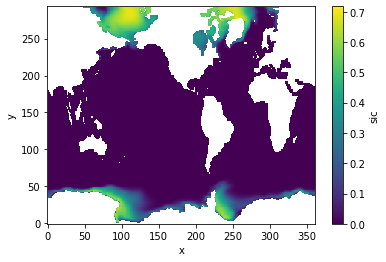

In [11]:
cnrm2x_sic.mean(axis=0).plot()

In [16]:
## Regrid the longrunmip data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = cnrm2x_sic.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False,
                        ignore_degenerate=True) ## FIX FOR CNRM morel
regridder

cnrm2x_sst_regrid = regridder(cnrm2x_sst)
cnrm_ctrl_sst_regrid = regridder(cnrm_ctrl_sst)

# REGRID SEA ICE
cnrm2x_sic_regrid = regridder(cnrm2x_sic)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


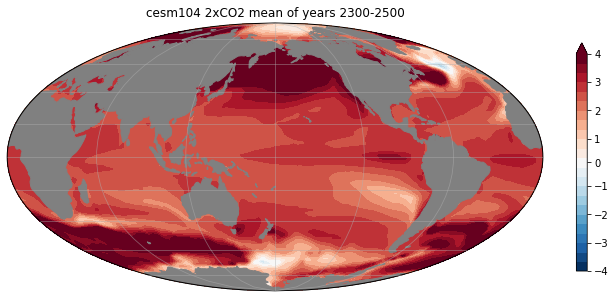

In [124]:
## checking the anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cnrm2x_sst_regrid - cnrm_ctrl_sst_regrid #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('cnrm 2xCO2 mean of years 2300-2500')
plt.show()

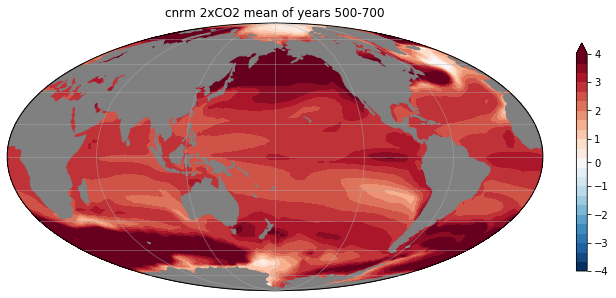

In [17]:
## checking the anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cnrm2x_sst_regrid - cnrm_ctrl_sst_regrid #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('cnrm 2xCO2 mean of years 500-700')
plt.show()

In [125]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  2.74


In [18]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  2.92


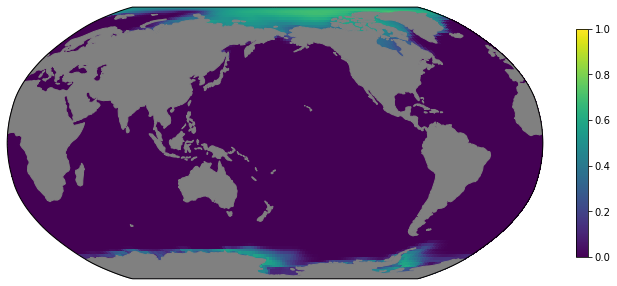

In [15]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = cnrm2x_sic_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title(dsname + " Holo + ecs2x")
plt.show()

#### Save cnrm

In [19]:
# ## Note: cesm104 SST is annual, but SIC is monthly 
cnrm_sst_anom = (cnrm2x_sst_regrid - cnrm_ctrl_sst_regrid).rename('sst')
# sstanom_prepped = cnrm_sst_anom
# sic_prepped = cnrm2x_sic_regrid

# model = 'cnrmcm61'
# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
# fname = model+'_sstanom_prepped.nc'
# sstanom_prepped.to_netcdf(path + fname)
# fname = model+'_sic_prepped.nc'
# sic_prepped.to_netcdf(path + fname)
# print('finished saving')

In [20]:
## load cnrm final 200 years
model = 'cnrmcm61'
path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
fname = model+'_sstanom_prepped.nc'
cnrm_sstanom_prepped = xr.open_dataset(path + fname)
fname = model+'_sic_prepped.nc'
cnrm_sic_prepped = xr.open_dataset(path + fname)
print('finished loading')

finished loading


# Load HadCM

In [21]:
model = 'HadCM3L'
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'

## annual mean SST
nyears = 200
## NOTE using 500-700 instead of 800-1000 for this model bc M Rugenstein note:
#https://data.iac.ethz.ch/longrunmip/modelouput/readme_specific_models.txt
#* "HadCM3L has a jump of about 80W/m2 in surface heat fluxes 
#* constructed by atmospheric variables hfls, hfss, rls, rsds, rsus after 800 years of control."

fname = 'tos_ann_HadCM3L_abrupt2x_1000.nc'
# lastyear = 700 #1000
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
had2x_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time')

fname = 'tos_ann_HadCM3L_control_1000.nc'
# lastyear = 700 #1000
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
had_ctrl_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time')

In [22]:
%%time
## sea ice monthly
fname = 'sic_mon_HadCM3L_abrupt2x_1000.nc'
sic_ds = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[12*(lastyear-nyears):12*(lastyear)] ## EDIT SEE ABOVE

montharr = np.tile(np.arange(1,12+1,1),len(sic_ds)//12)
had2x_sic = sic_ds.assign_coords(
    month=('time',montharr)).groupby('month').mean()

CPU times: user 15.2 s, sys: 67.4 ms, total: 15.3 s
Wall time: 15.5 s


In [23]:
## Regrid the longrunmip data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = had2x_sst.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.tos),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

had2x_sst_regrid = regridder(had2x_sst)
had_ctrl_sst_regrid = regridder(had_ctrl_sst)

## REGRID SEA ICE
data_for_regridding = had2x_sic.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)

had2x_sic_regrid = regridder(had2x_sic)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


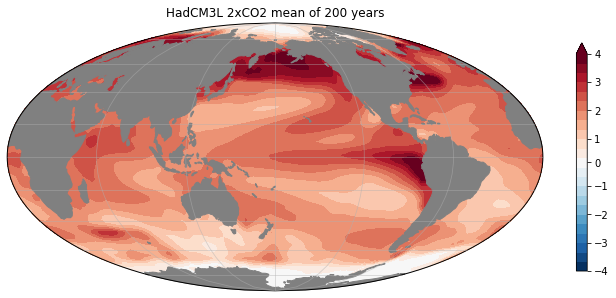

In [24]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = had2x_sst_regrid - had_ctrl_sst_regrid #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model + ' 2xCO2 mean of 200 years')
plt.show()

In [127]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  1.85


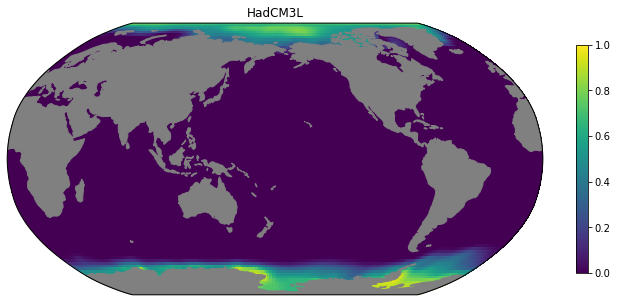

In [21]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = had2x_sic_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model)
plt.show()

#### Save Hadcm3

In [26]:
# ## Note: cesm104 SST is annual, but SIC is monthly 
had_sst_anom = (had2x_sst_regrid - had_ctrl_sst_regrid).rename('sst')
# sstanom_prepped = had_sst_anom
# sic_prepped = had2x_sic_regrid

# model = 'HadCM3L'
# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
# fname = model+'_sstanom_prepped.nc'
# sstanom_prepped.to_netcdf(path + fname)
# fname = model+'_sic_prepped.nc'
# sic_prepped.to_netcdf(path + fname)
# print('finished saving')

In [27]:
## load cnrm final 200 years
model = 'HadCM3L'
path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
fname = model+'_sstanom_prepped.nc'
hadcm_sstanom_prepped = xr.open_dataset(path + fname)
fname = model+'_sic_prepped.nc'
hadcm_sic_prepped = xr.open_dataset(path + fname)
print('finished loading')

finished loading


# Load MPI

In [28]:
model = 'mpiesm12'
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'

## annual mean SST
nyears = 200

fname = 'tos_ann_MPIESM12_abrupt2x_1000.nc'
# lastyear = 1000
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
mpi2x_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time').squeeze()

fname = 'tos_ann_MPIESM12_control_1500.nc'
# lastyear = 1500
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
mpi_ctrl_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time').squeeze()

In [29]:
%%time
## sea ice monthly
fname = 'sic_mon_MPIESM12_abrupt2x_1000.nc'
sic_ds = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[-12*nyears:].squeeze()

montharr = np.tile(np.arange(1,12+1,1),len(sic_ds)//12)
mpi2x_sic = sic_ds.assign_coords(
    month=('time',montharr)).groupby('month').mean()

CPU times: user 30.8 s, sys: 877 ms, total: 31.7 s
Wall time: 46.2 s


In [30]:
## Regrid the longrunmip data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = mpi2x_sst.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.tos),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

mpi2x_sst_regrid = regridder(mpi2x_sst)
mpi_ctrl_sst_regrid = regridder(mpi_ctrl_sst)

## REGRID SEA ICE
data_for_regridding = mpi2x_sic.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)

mpi2x_sic_regrid = regridder(mpi2x_sic)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


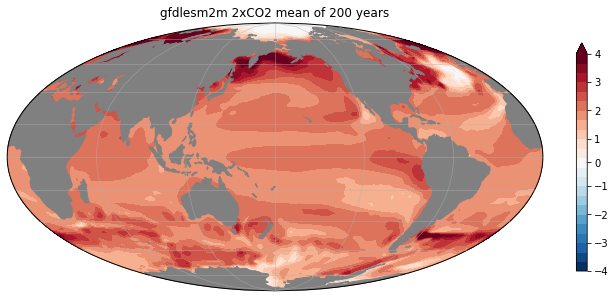

In [128]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = mpi2x_sst_regrid - mpi_ctrl_sst_regrid #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model + ' 2xCO2 mean of 200 years')
plt.show()

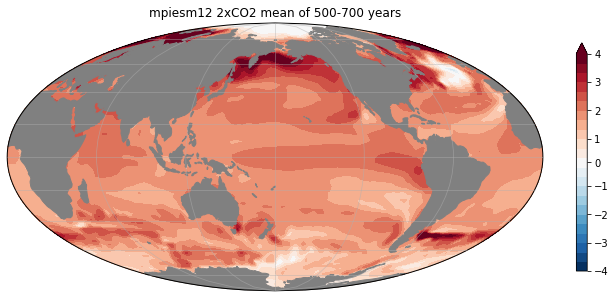

In [31]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = mpi2x_sst_regrid - mpi_ctrl_sst_regrid #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model + ' 2xCO2 mean of 500-700 years')
plt.show()

In [129]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  1.99


In [32]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  1.85


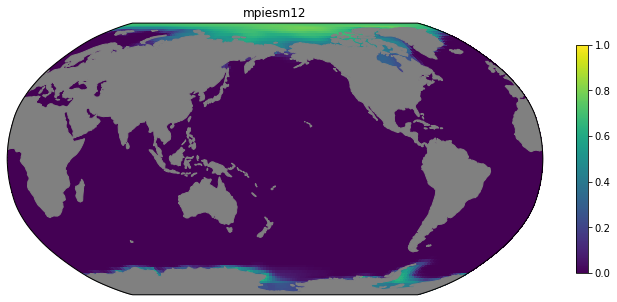

In [27]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = mpi2x_sic_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model)
plt.show()

In [28]:
model

'mpiesm12'

#### Save MPI

In [35]:
# ## Note: cesm104 SST is annual, but SIC is monthly 
mpi_sst_anom = (mpi2x_sst_regrid - mpi_ctrl_sst_regrid).rename('sst')
# sstanom_prepped = mpi_sst_anom
# sic_prepped = mpi2x_sic_regrid

# model = 'mpiesm12'
# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
# fname = model+'_sstanom_prepped.nc'
# sstanom_prepped.to_netcdf(path + fname)
# fname = model+'_sic_prepped.nc'
# sic_prepped.to_netcdf(path + fname)
# print('finished saving')

In [36]:
## load final 200 years
model = 'mpiesm12'
path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
fname = model+'_sstanom_prepped.nc'
mpi_sstanom_prepped = xr.open_dataset(path + fname)
fname = model+'_sic_prepped.nc'
mpi_sic_prepped = xr.open_dataset(path + fname)
print('finished loading')

finished loading


# Load MIROC

In [29]:
# %%time
# model = 'miroc32'
# lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'

# ## MONTHLY mean SST
# nyears = 200

# fname = 'tos_mon_MIROC32_1pct2x_2003.nc'
# # lastyear = 2003
# # tslice = slice(lastyear-nyears,lastyear+1)
# miroc2x_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos[-12*nyears:]

# montharr = np.tile(np.arange(1,12+1,1),len(miroc2x_sst)//12)
# miroc2x_sst = miroc2x_sst.assign_coords(
#     month=('time',montharr)).groupby('month').mean()

CPU times: user 25.5 s, sys: 1.19 s, total: 26.7 s
Wall time: 49.6 s


In [41]:
%%time
model = 'miroc32'
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'

## MONTHLY mean SST
nyears = 200

fname = 'tos_mon_MIROC32_1pct2x_2003.nc'
# lastyear = 2003
firstyear = comyr
# tslice = slice(lastyear-nyears,lastyear+1)
miroc2x_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos[12*firstyear:12*(firstyear+nyears)]

montharr = np.tile(np.arange(1,12+1,1),len(miroc2x_sst)//12)
miroc2x_sst = miroc2x_sst.assign_coords(
    month=('time',montharr)).groupby('month').mean()

CPU times: user 25 s, sys: 831 ms, total: 25.8 s
Wall time: 27.6 s


In [42]:
%%time
model = 'miroc32'
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'

## annual 1p4x
nyears = 200

fname = 'tos_ann_MIROC32_1pct4x_2002.nc'
lastyear = 2002
tslice = slice(lastyear-nyears,lastyear+1)
miroc4x_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time').squeeze()

CPU times: user 161 ms, sys: 118 ms, total: 279 ms
Wall time: 5.41 s


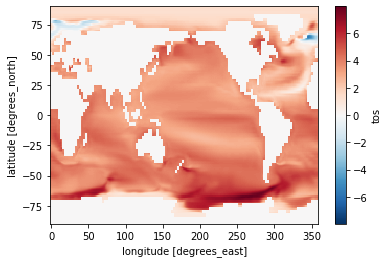

In [43]:
(miroc4x_sst - miroc2x_sst.mean(axis=0)).plot()

In [44]:
temp2x = xr.where(miroc2x_sst== 1.4999748,np.nan, miroc2x_sst)
tempctrl = xr.where(miroc_ctrl_sst== 1.4999942,np.nan, miroc_ctrl_sst)

NameError: name 'miroc_ctrl_sst' is not defined

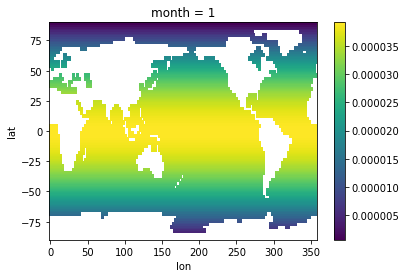

In [234]:
coswts = np.cos(np.deg2rad(temp2x.lat))
coswts = (coswts * (temp2x[0]/temp2x[0]))
coswts = coswts / coswts.sum()

coswts.plot()

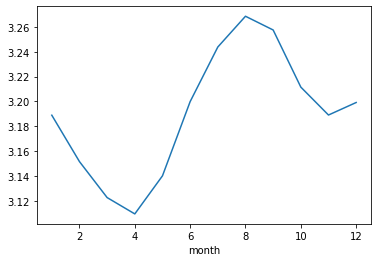

In [235]:
((miroc2x_sst-miroc_ctrl_sst)*coswts).sum(axis=(1,2)).plot()

In [45]:
%%time
fname = 'tos_mon_MIROC32_control_681.nc'
# lastyear = 681
miroc_ctrl_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos[-12*nyears:]

montharr = np.tile(np.arange(1,12+1,1),len(miroc_ctrl_sst)//12)
miroc_ctrl_sst = miroc_ctrl_sst.assign_coords(
    month=('time',montharr)).groupby('month').mean()

CPU times: user 25.2 s, sys: 800 ms, total: 26 s
Wall time: 35.7 s


In [46]:
%%time
## sea ice monthly
fname = 'sic_mon_MIROC32_1pct2x_2003.nc'

firstyear = comyr

# sic_ds = xr.open_dataset(
#     lrmpath + fname, decode_times=False).sic[-12*nyears:]
sic_ds = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[12*firstyear:12*(firstyear+nyears)]

montharr = np.tile(np.arange(1,12+1,1),len(sic_ds)//12)
miroc2x_sic = sic_ds.assign_coords(
    month=('time',montharr)).groupby('month').mean()

CPU times: user 25.4 s, sys: 1.57 s, total: 27 s
Wall time: 52 s


In [32]:
# %%time
# montharr = np.tile(np.arange(1,12+1,1),len(sic_ds)//12)
# miroc2x_sic = sic_ds.assign_coords(
#     month=('time',montharr)).groupby('month').mean()

CPU times: user 24.8 s, sys: 313 ms, total: 25.1 s
Wall time: 25.1 s


In [47]:
## Regrid the longrunmip data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = miroc2x_sst[0].to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.tos),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

miroc2x_sst_regrid = regridder(miroc2x_sst)
miroc_ctrl_sst_regrid = regridder(miroc_ctrl_sst)

## REGRID SEA ICE
data_for_regridding = miroc2x_sic.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)

miroc2x_sic_regrid = regridder(miroc2x_sic)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


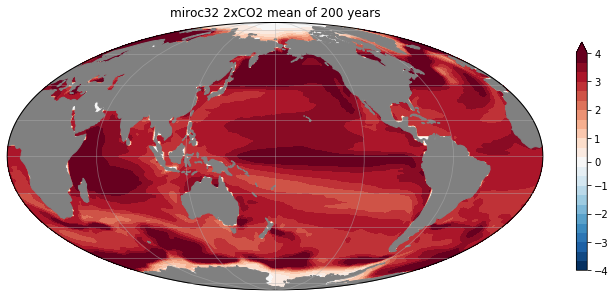

In [209]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = (miroc2x_sst - miroc_ctrl_sst).mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model + ' 2xCO2 mean of 200 years')
plt.show()

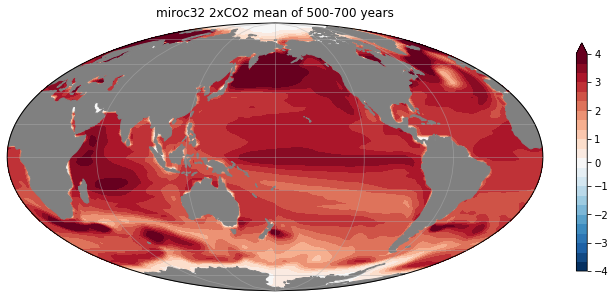

In [48]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = (miroc2x_sst_regrid - miroc_ctrl_sst_regrid).mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model + ' 2xCO2 mean of 500-700 years')
plt.show()

In [208]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  3.15


In [49]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  2.72


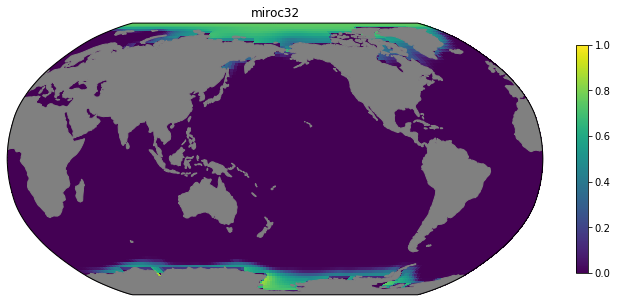

In [36]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = miroc2x_sic_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model)
plt.show()

In [111]:
model

'miroc32'

#### Save MIROC

In [51]:
# ## Note: MIROC SST is MONTHLY, AND SIC is monthly 
miroc_sst_anom = (miroc2x_sst_regrid - miroc_ctrl_sst_regrid).rename('sst')
# sstanom_prepped = miroc_sst_anom
# sic_prepped = miroc2x_sic_regrid

# model = 'miroc32'
# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
# fname = model+'_sstanom_prepped_monthly.nc'
# sstanom_prepped.to_netcdf(path + fname)
# fname = model+'_sic_prepped.nc'
# sic_prepped.to_netcdf(path + fname)
# print('finished saving')

In [53]:
## load final 200 years
model = 'miroc32'
path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
fname = model+'_sstanom_prepped_monthly.nc'
miroc_sstanom_prepped = xr.open_dataset(path + fname)
fname = model+'_sic_prepped.nc'
miroc_sic_prepped = xr.open_dataset(path + fname)
print('finished loading')

finished loading


# Load GFDL CM3

In [54]:
%%time
model = 'gfdlcm3'
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'

## annual mean SST
nyears = 200

fname = 'tos_ann_GFDLCM3_1pct2x_5000.nc'
# lastyear = 5000
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
gfdl2x_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time')

fname = 'tos_ann_GFDLCM3_control_0.nc'
# lastyear = 5000
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
gfdl_ctrl_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.isel(
    time=tslice).mean(dim='time')

# ## FIX GRID PROBLEM
# arr = gfdl2x_sst
# arr1 = arr[:,280:]
# arr2 = arr[:,0:280]
# arr2['xt_ocean'] = arr2.xt_ocean+360
# gfdl2x_sst = xr.merge([arr1,arr2]).tos

# arr = gfdl_ctrl_sst
# arr1 = arr[:,280:]
# arr2 = arr[:,0:280]
# arr2['XT_OCEAN'] = arr2.XT_OCEAN+360
# gfdl_ctrl_sst = xr.merge([arr1,arr2]).tos

CPU times: user 485 ms, sys: 504 ms, total: 989 ms
Wall time: 8.05 s


Check starting positions

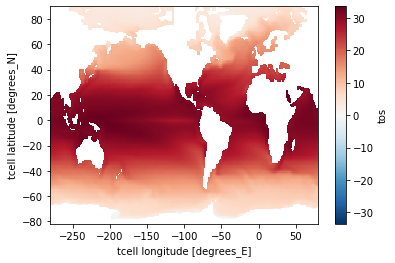

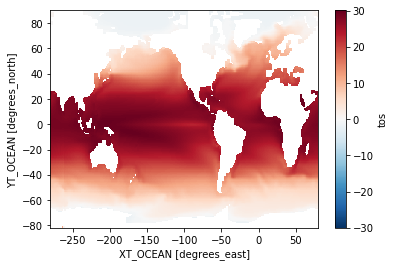

In [38]:
## see that these are offset slightly
gfdl2x_sst.plot()
plt.show()

gfdl_ctrl_sst.plot()
plt.show()

In [43]:
## more nans when diff the data, so need to fix grids
print(np.isnan(gfdl2x_sst).sum().values)
print(np.isnan(gfdl_ctrl_sst).sum().values)
print(np.isnan(gfdl2x_sst.values - gfdl_ctrl_sst.values).sum())

23889
23887
32037


280


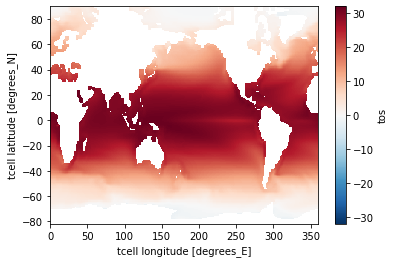

In [55]:
## fix 1
arr = gfdl2x_sst
tempind = arr.xt_ocean.where(arr.xt_ocean > 0).argmin().values
print(tempind)
arr1 = arr[:,tempind:]
arr2 = arr[:,0:tempind]
arr2['xt_ocean'] = arr2.xt_ocean+360
gfdl2x_sst_merged = xr.merge([arr1,arr2]).tos
gfdl2x_sst_merged.plot()
plt.show()

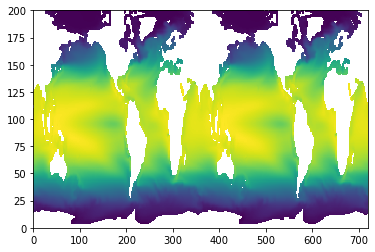

In [56]:
arr = gfdl_ctrl_sst
arr_double = np.tile(arr,2)
plt.pcolormesh(arr_double)
plt.show()

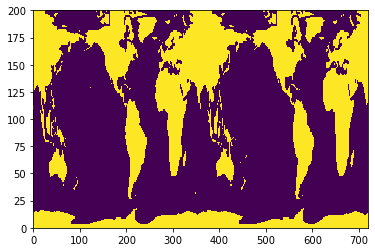

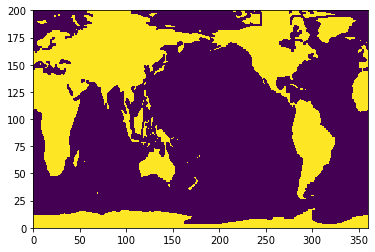

In [57]:
doublemask = np.where(np.isnan(arr_double),1,0)
plt.pcolormesh(doublemask)
plt.show()

goodmask = np.where(np.isnan(gfdl2x_sst_merged),1,0)
plt.pcolormesh(goodmask)
plt.show()

In [58]:
## get list of all possible mask mismatches
temp = [np.abs(doublemask[:,i:i+360] - goodmask).sum() for i in range(360)]

## best match has this many mismatches
print(np.min(temp))
argtemp = np.argmin(temp)
print(argtemp)

0
280


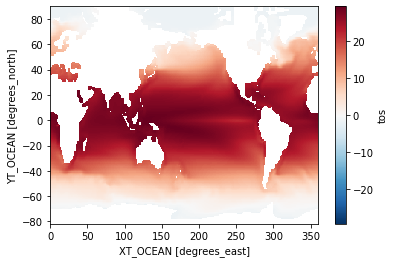

In [59]:
## fixed version
arr = gfdl_ctrl_sst
arr1 = arr[:,argtemp:]
arr2 = arr[:,0:argtemp]
arr2['XT_OCEAN'] = arr2.XT_OCEAN+360
gfdl_ctrl_sst_merged = xr.merge([arr1,arr2]).tos
gfdl_ctrl_sst_merged.plot()

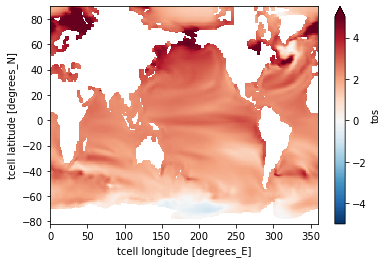

In [60]:
(gfdl2x_sst_merged - gfdl_ctrl_sst_merged.values).plot(cmap='RdBu_r',vmax=5,vmin=-5)
plt.show()

In [77]:
## STILL MESSED UP ^^

In [61]:
%%time
## sea ice monthly
fname = 'sic_mon_GFDLCM3_1pct2x_5000.nc'

# sic_ds = xr.open_dataset(
#     lrmpath + fname, decode_times=False).sic[-12*nyears:]
sic_ds = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[12*comyr:12*(comyr+nyears)]


montharr = np.tile(np.arange(1,12+1,1),len(sic_ds)//12)
gfdl2x_sic = sic_ds.assign_coords(
    month=('time',montharr)).groupby('month').mean()

## FIX GRID PROBLEM
arr = gfdl2x_sic
arr1 = arr[:,:,279:]
arr2 = arr[:,:,0:279]
arr2['xt'] = arr2.xt+360
gfdl2x_sic = xr.merge([arr1,arr2]).sic

CPU times: user 38.5 s, sys: 2.63 s, total: 41.1 s
Wall time: 1min 45s


#### Fix grid problem

In [245]:
# ## Regrid the longrunmip data
# ## use existing bc as target grid

# newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
# newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

# data_for_regridding = gfdl2x_sst.to_dataset()
# data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.tos),1,0)

# regridder = xe.Regridder(data_for_regridding, newgrid,
#                          method='bilinear',
#                          periodic=True,
#                          extrap_method='inverse_dist',extrap_num_src_pnts=8,
#                          # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
#                          reuse_weights=False)
# regridder

# gfdl2x_sst_regrid = regridder(gfdl2x_sst)
# gfdl_ctrl_sst_regrid = regridder(gfdl_ctrl_sst)

# ## REGRID SEA ICE
# data_for_regridding = gfdl2x_sic.to_dataset()
# data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

# regridder = xe.Regridder(data_for_regridding, newgrid,
#                          method='bilinear',
#                          periodic=True,
#                          extrap_method='inverse_dist',extrap_num_src_pnts=8,
#                          # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
#                          reuse_weights=False)

# gfdl2x_sic_regrid = regridder(gfdl2x_sic)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:595: UserWarning: Using dimensions ('YT_OCEAN', 'XT_OCEAN') from data variable tos as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib

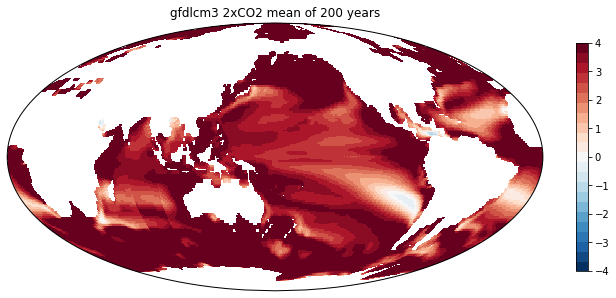

In [255]:
# ## checking the 4xCO2 anomaly pattern after regridding
# nlevs = 6*4 ## must be even
# vabs = 4
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

# fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
#                       subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
# axtemp = ax
# plt.sca(axtemp)

# ds = gfdl2x_sst - gfdl_ctrl_sst.values #.mean(axis=0)
# ## add cyclic point
# # lon_idx = ds.dims.index('lon')
# # lon = ds.coords['lon']
# # wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# # plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
# #             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
# #             transform=ccrs.PlateCarree())
# plt.pcolormesh(ds.xt_ocean, ds.yt_ocean, ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# # plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
# # axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# # axtemp.coastlines(color='k',zorder=1)
# # axtemp.gridlines(zorder=6,alpha=0.5)
# plt.title(model + ' 2xCO2 mean of 200 years')
# plt.show()

In [247]:
print('SST anom: ', (ds * cesm2x_sst_regrid.TAREA/cesm2x_sst_regrid.TAREA.sum()).sum().values.round(2))

SST anom:  2.53


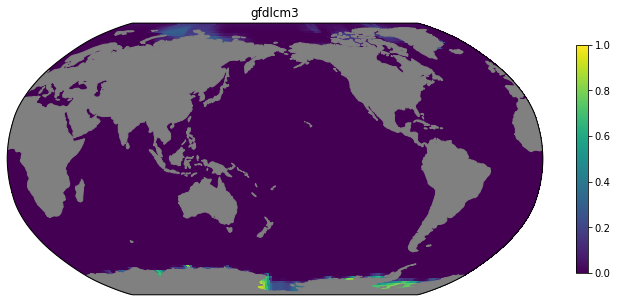

In [123]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = gfdl2x_sic_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model)
plt.show()

#### Save GFDL CM3

In [78]:
# ## Note: SST is annual, but SIC is monthly 
# gfdl_sst_anom = (gfdl2x_sst_regrid - gfdl_ctrl_sst_regrid).rename('sst')
# sstanom_prepped = gfdl_sst_anom
# sic_prepped = gfdl2x_sic_regrid

# model = 'gfdlcm3'
# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
# fname = model+'_sstanom_prepped.nc'
# sstanom_prepped.to_netcdf(path + fname)
# fname = model+'_sic_prepped.nc'
# sic_prepped.to_netcdf(path + fname)
# print('finished saving')

# Load GFDL ESM2M

In [62]:
%%time
model = 'gfdlesm2m'
lrmpath = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'

## annual mean SST
nyears = 200

fname = 'tos_ann_GFDLESM2M_1pct2x_4500.nc'
# lastyear = 4500
lastyear = comyr + nyears
# tslice = slice(lastyear-nyears,lastyear+1)
gfdl2x_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.squeeze().isel(
    time=tslice).mean(dim='time')

fname = 'tos_ann_GFDLESM2M_control_1340.nc'
# lastyear = 1340 
lastyear = comyr + nyears
tslice = slice(lastyear-nyears,lastyear+1)
gfdl_ctrl_sst = xr.open_dataset(lrmpath + fname, decode_times=False).tos.squeeze().isel(
    time=tslice).mean(dim='time')

CPU times: user 484 ms, sys: 348 ms, total: 832 ms
Wall time: 9.75 s


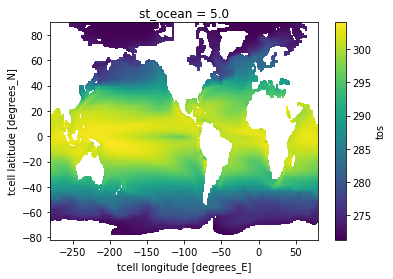

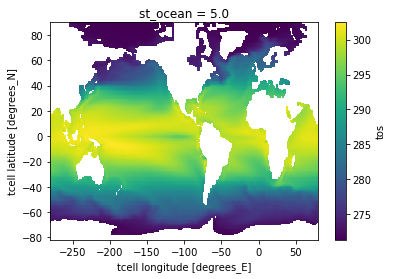

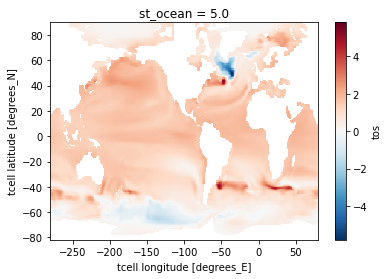

In [63]:
gfdl2x_sst.plot()
plt.show()

gfdl_ctrl_sst.plot()
plt.show()

(gfdl2x_sst - gfdl_ctrl_sst).plot()
plt.show()

280


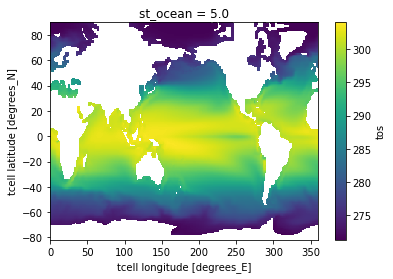

In [64]:
## fix 1
arr = gfdl2x_sst
tempind = arr.xt_ocean.where(arr.xt_ocean > 0).argmin().values
print(tempind)
arr1 = arr[:,tempind:]
arr2 = arr[:,0:tempind]
arr2['xt_ocean'] = arr2.xt_ocean+360
gfdl2x_sst_merged = xr.merge([arr1,arr2]).tos
gfdl2x_sst_merged.plot()
plt.show()

280


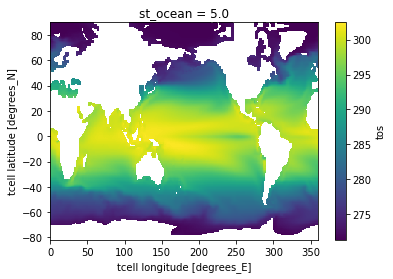

In [65]:
## fix 2
arr = gfdl_ctrl_sst
tempind = arr.xt_ocean.where(arr.xt_ocean > 0).argmin().values
print(tempind)
arr1 = arr[:,tempind:]
arr2 = arr[:,0:tempind]
arr2['xt_ocean'] = arr2.xt_ocean+360
gfdl_ctrl_sst_merged = xr.merge([arr1,arr2]).tos
gfdl_ctrl_sst_merged.plot()
plt.show()

In [66]:
%%time
## sea ice monthly
fname = 'sic_mon_GFDLESM2M_1pct2x_4500.nc'
# sic_ds = xr.open_dataset(
#     lrmpath + fname, decode_times=False).sic[-12*nyears:]
sic_ds = xr.open_dataset(
    lrmpath + fname, decode_times=False).sic[12*comyr:12*(comyr + nyears)]

montharr = np.tile(np.arange(1,12+1,1),len(sic_ds)//12)
gfdl2x_sic = sic_ds.assign_coords(
    month=('time',montharr)).groupby('month').mean()
gfdl2x_sic = gfdl2x_sic/100

CPU times: user 38.2 s, sys: 2.52 s, total: 40.7 s
Wall time: 1min 48s


279


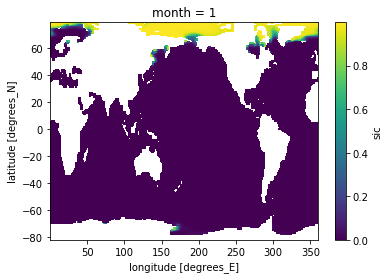

In [67]:
## fix 3
arr = gfdl2x_sic
tempind = arr.xt.where(arr.xt > 0).argmin().values
print(tempind)
arr1 = arr[:,:,tempind:]
arr2 = arr[:,:,0:tempind]
arr2['xt'] = arr2.xt+360
gfdl2x_sic_merged = xr.merge([arr1,arr2]).sic
gfdl2x_sic_merged[0].plot()
plt.show()

In [68]:
## Regrid the longrunmip data
## use existing bc as target grid

newgrid = xr.open_dataset('/home/disk/sipn/vcooper/nobackup/lgm/cam_sst/holo_bc_final_prediddle_v2.nc').isel(time=0)
newgrid['mask'] = xr.where(~np.isnan(newgrid.SST_cpl),1,0)

data_for_regridding = gfdl2x_sst_merged.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.tos),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)
regridder

gfdl2x_sst_regrid = regridder(gfdl2x_sst_merged)
gfdl_ctrl_sst_regrid = regridder(gfdl_ctrl_sst_merged)

## REGRID SEA ICE
data_for_regridding = gfdl2x_sic_merged.to_dataset()
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8,
                         # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
                         reuse_weights=False)

gfdl2x_sic_regrid = regridder(gfdl2x_sic_merged)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


In [135]:
# ## REGRID SEA ICE
# data_for_regridding = gfdl2x_sic_merged.to_dataset()
# data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sic[0]),1,0)

# regridder = xe.Regridder(data_for_regridding, newgrid,
#                          method='bilinear',
#                          periodic=True,
#                          extrap_method='inverse_dist',extrap_num_src_pnts=8,
#                          # filename='bilinear_CMIPsst-to-1.9x2.5_per_extrapID8.nc',
#                          reuse_weights=False)

# gfdl2x_sic_regrid = regridder(gfdl2x_sic_merged)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/disk/atmos/vcooper/miniconda3/envs/beauchard-clone/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


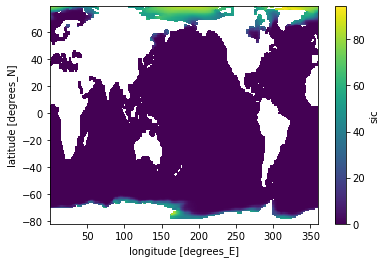

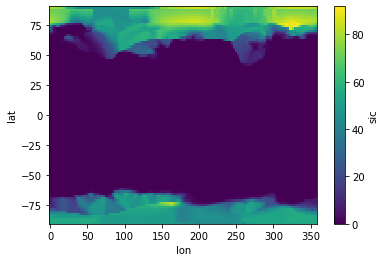

In [138]:
gfdl2x_sic_merged.mean(axis=0).plot()
plt.show()

gfdl2x_sic_regrid.mean(axis=0).plot()
plt.show()

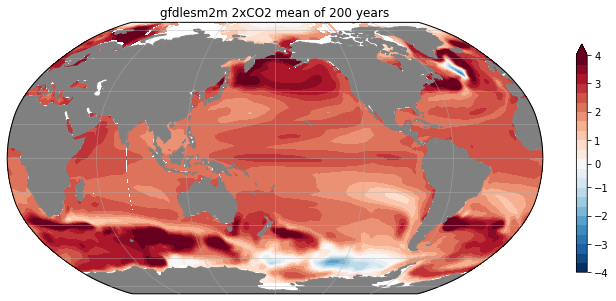

In [103]:
## checking the 4xCO2 anomaly pattern before regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = gfdl2x_sst - gfdl_ctrl_sst #.mean(axis=0)
## add cyclic point
# lon_idx = ds.dims.index('lon')
# lon = ds.coords['lon']
# wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(ds.xt_ocean, ds.yt_ocean, ds,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model + ' 2xCO2 mean of 200 years')
plt.show()

In [ ]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = gfdl2x_sst_regrid - gfdl_ctrl_sst_regrid #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model + ' 2xCO2 mean of 200 years')
plt.show()

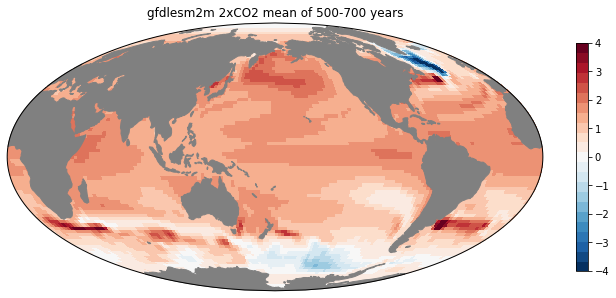

In [69]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = gfdl2x_sst_regrid - gfdl_ctrl_sst_regrid #.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

# plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
#             transform=ccrs.PlateCarree())
plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model + ' 2xCO2 mean of 500-700 years')
plt.show()

In [133]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  2.24


In [70]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  1.22


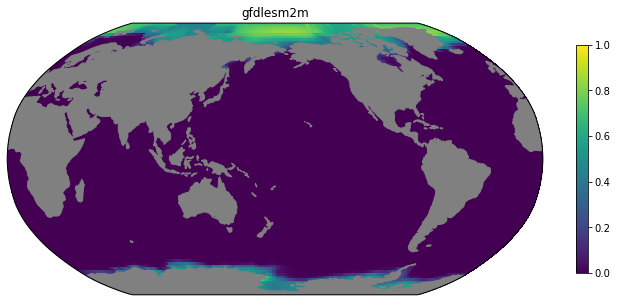

In [142]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = gfdl2x_sic_regrid.mean(axis=0)
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title(model)
plt.show()

In [143]:
model

'gfdlesm2m'

#### Save gfdlesm2m

In [71]:
## Note: SST is annual, but SIC is monthly 
gfdl_sst_anom = (gfdl2x_sst_regrid - gfdl_ctrl_sst_regrid).rename('sst')
# sstanom_prepped = gfdl_sst_anom
# sic_prepped = gfdl2x_sic_regrid

# model = 'gfdlesm2m'
# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
# fname = model+'_sstanom_prepped.nc'
# sstanom_prepped.to_netcdf(path + fname)
# fname = model+'_sic_prepped.nc'
# sic_prepped.to_netcdf(path + fname)
# print('finished saving')

In [72]:
## load final 200 years
model = 'gfdlesm2m'
path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'+model+'/'
fname = model+'_sstanom_prepped.nc'
gfdl_sstanom_prepped = xr.open_dataset(path + fname)
fname = model+'_sic_prepped.nc'
gfdl_sic_prepped = xr.open_dataset(path + fname)
print('finished loading')

finished loading


## Combine data and check

In [73]:
## dataset
sst_anoms_ds_all = xr.concat([cesm_sst_anom, 
           cnrm_sst_anom, 
           had_sst_anom, 
           miroc_sst_anom.mean(axis=0), 
           mpi_sst_anom, 
           gfdl_sst_anom],
           dim='model')

sst_anoms_ds_all = sst_anoms_ds_all.drop(['depth','st_ocean'])

dimlist = list(cesm2x_sic_regrid.dims)
dimlist = np.append(['model'],dimlist)

sic_ds_all = xr.DataArray(data = np.stack([cesm2x_sic_regrid, 
                              cnrm2x_sic_regrid, 
                              had2x_sic_regrid, 
                              miroc2x_sic_regrid, 
                              mpi2x_sic_regrid, 
                              gfdl2x_sic_regrid]),
             coords = cesm2x_sic_regrid.coords,
             dims = dimlist)

In [114]:
miroc_sstanom_prepped

<xarray.Dataset>
Dimensions:  (month: 12, lon: 144, lat: 96)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Data variables:
    sst      (month, lat, lon) float64 ...

In [116]:
## old dataset of final 200 years
sst_anoms_ds_all_prepped = xr.concat([cesm_sstanom_prepped, 
           cnrm_sstanom_prepped, 
           hadcm_sstanom_prepped, 
           miroc_sstanom_prepped.mean(dim='month'), 
           mpi_sstanom_prepped, 
           gfdl_sstanom_prepped],
           dim='model')

sst_anoms_ds_all_prepped = sst_anoms_ds_all_prepped.drop(['depth','st_ocean'])

# dimlist = list(cesm2x_sic_regrid.dims)
# dimlist = np.append(['model'],dimlist)

# sic_ds_all = xr.DataArray(data = np.stack([cesm2x_sic_regrid, 
#                               cnrm2x_sic_regrid, 
#                               had2x_sic_regrid, 
#                               miroc2x_sic_regrid, 
#                               mpi2x_sic_regrid, 
#                               gfdl2x_sic_regrid]),
#              coords = cesm2x_sic_regrid.coords,
#              dims = dimlist)

In [117]:
# dict
sst_anoms = {}
sst_anoms = {'cesm104' : cesm_sst_anom,
             'cnrmcm61' : cnrm_sst_anom,
             'hadcm3l'  : had_sst_anom,
             'miroc32': miroc_sst_anom.mean(axis=0), # monthly
             'mpiesm12'  : mpi_sst_anom,
             'gfdlesm2m' : gfdl_sst_anom}

sic_2xs = {  'cesm104' : cesm2x_sic_regrid,
             'cnrmcm61' : cnrm2x_sic_regrid,
             'hadcm3l'  : had2x_sic_regrid,
             'miroc32': miroc2x_sic_regrid,
             'mpiesm12'  : mpi2x_sic_regrid,
             'gfdlesm2m' : gfdl2x_sic_regrid}
keylist = list(sst_anoms.keys())

In [75]:
## assign model names
sst_anoms_ds_all = sst_anoms_ds_all.assign_coords({"model": ("model", keylist)})
sic_ds_all = sic_ds_all.assign_coords({"model": ("model", keylist)})

In [367]:
sst_anom_mean  = cesm_sst_anom - cesm_sst_anom

for key,val in sst_anoms.items():
#     print(val.shape)
    print(key, (val * oceanarea/oceanarea.sum()).sum().values.round(2))
    sst_anom_mean = sst_anom_mean + val
    
sst_anom_mean = sst_anom_mean / len(sst_anoms.keys())

cesm104 2.08
cnrmcm61 2.74
hadcm3l 1.85
miroc32 3.15
mpiesm12 1.99
gfdlesm2m 2.24


cesm104 2.08
cnrmcm61 2.74
hadcm3l 1.85
miroc32 3.15
mpiesm12 1.99
gfdlesm2m 2.24


In [127]:
## loading old version, should match above
## assign model names
sst_anoms_ds_all_prepped = sst_anoms_ds_all_prepped.assign_coords({"model": ("model", keylist)})
# sic_ds_all = sic_ds_all.assign_coords({"model": ("model", keylist)})

## 500 700 version
# sst_anom_mean  = cesm_sst_anom - cesm_sst_anom

for i,val in enumerate(sst_anoms_ds_all_prepped.sst):
    print(val.model.values, (val * oceanarea/oceanarea.sum()).sum().values.round(2))
#     sst_anom_mean = sst_anom_mean + val
    
# sst_anom_mean = sst_anom_mean / len(sst_anoms.keys())

cesm104 2.08
cnrmcm61 2.74
hadcm3l 1.85
miroc32 3.15
mpiesm12 1.99
gfdlesm2m 2.24


In [119]:
## 500 700 version
sst_anom_mean  = cesm_sst_anom - cesm_sst_anom

for key,val in sst_anoms.items():
#     print(val.shape)
    print(key, (val * oceanarea/oceanarea.sum()).sum().values.round(2))
    sst_anom_mean = sst_anom_mean + val
    
sst_anom_mean = sst_anom_mean / len(sst_anoms.keys())

cesm104 1.81
cnrmcm61 2.92
hadcm3l 1.85
miroc32 2.72
mpiesm12 1.85
gfdlesm2m 1.22


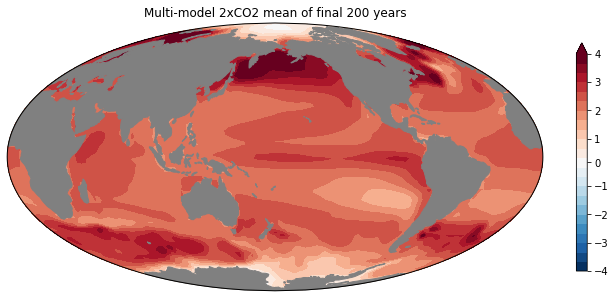

In [241]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = sst_anom_mean
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Multi-model 2xCO2 mean of final 200 years')
plt.show()

In [276]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  2.34


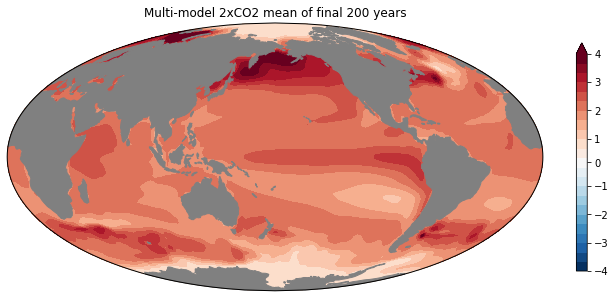

In [77]:
## repeat 500-700
## checking the 2xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 4
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = sst_anoms_ds_all.mean(dim='model')
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Multi-model 2xCO2 mean of final 200 years')
plt.show()

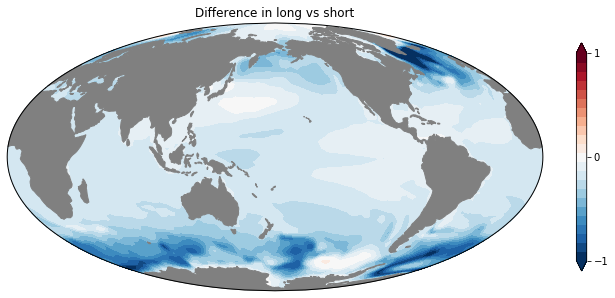

In [133]:
## repeat 500-700
## checking the 2xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 1
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = sst_anoms_ds_all.mean(dim='model') - sst_anoms_ds_all_prepped.mean(dim='model')
ds = ds.sst
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='both', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Difference in long vs short')
plt.show()

In [78]:
print('SST anom: ', (ds * oceanarea/oceanarea.sum()).sum().values.round(2))

SST anom:  2.06


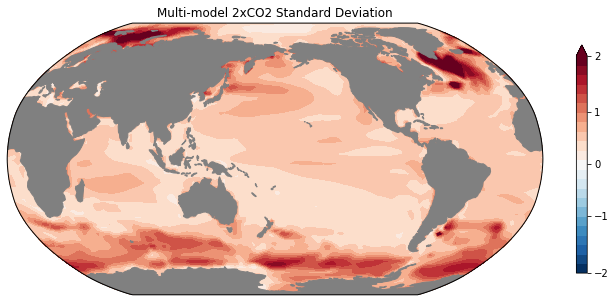

In [374]:
## checking the 4xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 2
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = sst_anoms_ds_all.std(dim='model')
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='max', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,1))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Multi-model 2xCO2 Standard Deviation')
plt.show()

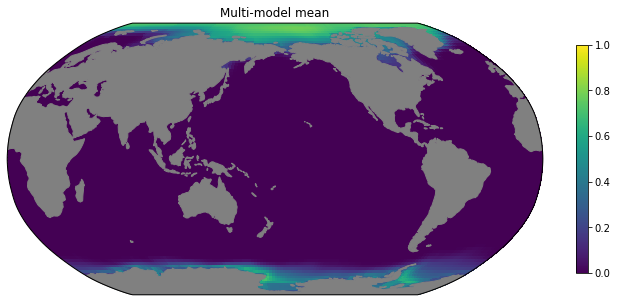

In [375]:
## infilled data anomaly
# nlevs = 5*4 ## must be even
vabs = 1
# levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
# cmap=plt.cm.get_cmap('RdBu_r', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = sic_ds_all.mean(axis=(0,1))
## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.pcolormesh(wrap_lon, ds.lat, wrap_ds,
            cmap = 'viridis', vmin=0,vmax=vabs,#levels=levs, 
            transform=ccrs.PlateCarree())
# plt.contourf(wrap_lon, ds.lat, wrap_ds,
#             cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,
#             transform=ccrs.PlateCarree())

plt.colorbar(shrink=0.6)
# plt.colorbar(shrink=0.6,ticks=np.arange(-vabs,vabs+0.1,2))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
axtemp.set_global()
plt.title('Multi-model mean')
plt.show()

#### Save means and full group

In [79]:
## Note: SST is annual, but SIC is monthly 
sstanom_prepped = sst_anoms_ds_all
sic_prepped = sic_ds_all.rename('sic')

# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/'
# fname = 'multimodel'+'_sstanom_prepped.nc'
# sstanom_prepped.to_netcdf(path + fname)

# fname = 'multimodel'+'_sic_prepped.nc'
# sic_prepped.to_netcdf(path + fname)
# print('finished saving')

finished saving


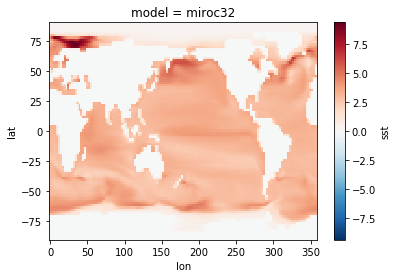

In [410]:
sstanom_prepped[3].plot()

## getting seasonality of anomalies from MIROC

In [80]:
anom_rmmean = (miroc2x_sst_regrid - miroc_ctrl_sst_regrid) - (
    miroc2x_sst_regrid - miroc_ctrl_sst_regrid).mean(dim='month')

In [402]:
# path = '/home/disk/sipn/vcooper/nobackup/lgm/longrunmip/miroc32/'
# fname = 'miroc32'+'_sstanom-rmean.nc'
# anom_rmmean.to_netcdf(path+fname)

# Green's functions comparison and estimates

In [82]:
gf = xr.open_dataset('./ref_files/CAM4-CAM5_Greens_Function.nc')

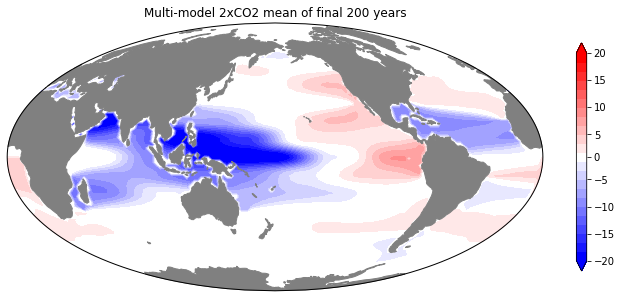

In [108]:
## repeat 500-700
## checking the 2xCO2 anomaly pattern after regridding
nlevs = 6*4 ## must be even
vabs = 20
levs = np.delete(np.linspace(-vabs,vabs,nlevs+1),nlevs//2)
cmap=plt.cm.get_cmap('bwr', nlevs-1)

fig,ax = plt.subplots(1,1,figsize=(12,7), dpi=72, 
                      subplot_kw={'projection':ccrs.Mollweide(central_longitude=180)})
axtemp = ax
plt.sca(axtemp)

ds = sst_anoms_ds_all.mean(dim='model')
ds = ds *  gf.TOA_CAM5.values / (ds * gf.TAS_CAM5.values).sum().values
ds = ds * np.where(ds == 0,0,1).sum()

## add cyclic point
lon_idx = ds.dims.index('lon')
lon = ds.coords['lon']
wrap_ds, wrap_lon = add_cyclic_point(ds.values, coord=lon, axis=lon_idx)

plt.contourf(wrap_lon, ds.lat, wrap_ds.data,
            cmap = cmap, vmin=-vabs,vmax=vabs,levels=levs,extend='both', 
            transform=ccrs.PlateCarree())
# plt.pcolormesh(wrap_lon, ds.lat, wrap_ds.data,
#             cmap = cmap, vmin=-vabs,vmax=vabs,#levels=levs, 
#             transform=ccrs.PlateCarree())

# plt.colorbar(shrink=0.6)
plt.colorbar(shrink=0.6,ticks=np.arange(-int(vabs),vabs+0.1,5))
axtemp.add_feature(cfeature.LAND,alpha=1,color='0.5',zorder=1)
# axtemp.coastlines(color='k',zorder=1)
# axtemp.gridlines(zorder=6,alpha=0.5)
plt.title('Multi-model 2xCO2 mean of final 200 years')
plt.show()

In [173]:
## errors
ds = sst_anoms_ds_all
ds = ds *  gf.TOA_CAM5.values / (ds * gf.TAS_CAM5.values).sum(dim=['lat','lon'])
sd = ds.sum(dim=['lat','lon']).values.std(ddof=1)
print('Averaging years 500-700')
print('Std. Deviation in CAM5 GF: ', sd.round(3), 'W/m2/K')

## errors
ds = sst_anoms_ds_all_prepped.sst
ds = ds *  gf.TOA_CAM5.values / (ds * gf.TAS_CAM5.values).sum(dim=['lat','lon'])
sd = ds.sum(dim=['lat','lon']).values.std(ddof=1)
print('Averaging final 200 years of each simulation')
print('Std. Deviation in CAM5 GF: ', sd.round(3), 'W/m2/K')

Averaging years 500-700
Std. Deviation in CAM5 GF:  0.184 W/m2/K
Averaging final 200 years of each simulation
Std. Deviation in CAM5 GF:  0.1 W/m2/K


0.09971312994137696

In [183]:
## errors
ds = sst_anoms_ds_all
ds = ds *  gf.TOA_CAM4.values / (ds * gf.TAS_CAM4.values).sum(dim=['lat','lon'])
sd = ds.sum(dim=['lat','lon']).values.std(ddof=1)
print('Averaging years 500-700')
print('Std. Deviation in CAM4 GF: ', sd.round(3), 'W/m2/K')

## errors
ds = sst_anoms_ds_all_prepped.sst
ds = ds *  gf.TOA_CAM4.values / (ds * gf.TAS_CAM4.values).sum(dim=['lat','lon'])
sd = ds.sum(dim=['lat','lon']).values.std(ddof=1)
print('Averaging final 200 years of each simulation')
print('Std. Deviation in CAM4 GF: ', sd.round(3), 'W/m2/K')

Averaging years 500-700
Std. Deviation in CAM4 GF:  0.387 W/m2/K
Averaging final 200 years of each simulation
Std. Deviation in CAM4 GF:  0.164 W/m2/K


In [145]:
## CAM5

## 500 - 700 feedback
ds = sst_anoms_ds_all.mean(dim='model')
ds = ds *  gf.TOA_CAM5.values / (ds * gf.TAS_CAM5.values).sum().values
print('Averaging years 500-700')
print('CAM5 GF: ', ds.sum().values.round(2))

## long feedback
ds = sst_anoms_ds_all_prepped.mean(dim='model').sst
ds = ds *  gf.TOA_CAM5.values / (ds * gf.TAS_CAM5.values).sum().values
print('Averaging final 200 years of each simulation')
print('CAM5 GF: ', ds.sum().values.round(2))

Averaging years 500-700
CAM5 GF:  -1.58
Averaging final 200 years of each simulation
CAM5 GF:  -1.55


In [146]:
## CAM 4
## 500 - 700 feedback
ds = sst_anoms_ds_all.mean(dim='model')
ds = ds *  gf.TOA_CAM4.values / (ds * gf.TAS_CAM4.values).sum().values
print('Averaging years 500-700')
print('CAM4 GF: ', ds.sum().values.round(2))

## long feedback
ds = sst_anoms_ds_all_prepped.mean(dim='model').sst
ds = ds *  gf.TOA_CAM4.values / (ds * gf.TAS_CAM4.values).sum().values
print('Averaging final 200 years of each simulation')
print('CAM4 GF: ', ds.sum().values.round(2))

Averaging years 500-700
CAM4 GF:  -2.27
Averaging final 200 years of each simulation
CAM4 GF:  -2.15


In [139]:
print(.5826 - .5471)
print(.273 - .152)

0.035499999999999976
0.12100000000000002


In [200]:
## checking specific models for which truth is known

## CAM5
ds = sst_anoms_ds_all
ds = ds *  gf.TOA_CAM5.values / (ds * gf.TAS_CAM5.values).sum(dim=['lat','lon'])
ds = ds.sum(dim=['lat','lon'])
ds_500 = copy.deepcopy(ds)

ds = sst_anoms_ds_all_prepped.sst
ds = ds *  gf.TOA_CAM5.values / (ds * gf.TAS_CAM5.values).sum(dim=['lat','lon'])
ds = ds.sum(dim=['lat','lon'])
ds

<xarray.DataArray 'sst' (model: 6)>
array([-1.3757727 , -1.48125216, -1.57493766, -1.61856562, -1.5605156 ,
       -1.64739749])
Coordinates:
  * model    (model) <U9 'cesm104' 'cnrmcm61' ... 'mpiesm12' 'gfdlesm2m'

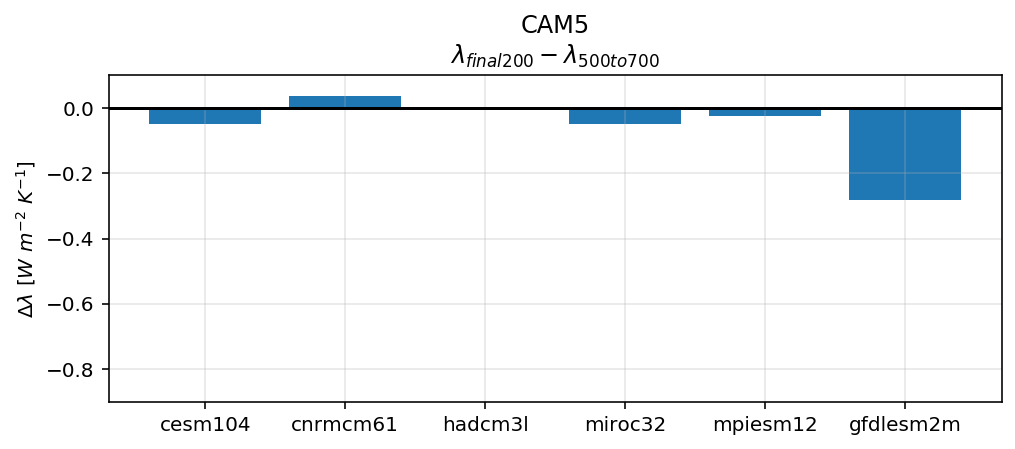

In [202]:
plt.figure(figsize=(8,3),dpi=72*2)
plt.bar(sst_anoms_ds_all_prepped.sst.model.values, ds_500 - ds)
plt.axhline(0,c='k')
plt.ylabel('$\Delta \lambda \ [W \ m^{-2} \ K^{-1}]$')
plt.title('CAM5\n' + 
          '$\lambda_{final200} - \lambda_{500to700}$')
plt.grid(True,alpha=0.3)
plt.ylim(-0.9,0.1)
plt.show()

In [203]:
## checking specific models for which truth is known

## CAM4
ds = sst_anoms_ds_all
ds = ds *  gf.TOA_CAM4.values / (ds * gf.TAS_CAM4.values).sum(dim=['lat','lon'])
ds = ds.sum(dim=['lat','lon'])
ds_500 = copy.deepcopy(ds)

ds = sst_anoms_ds_all_prepped.sst
ds = ds *  gf.TOA_CAM4.values / (ds * gf.TAS_CAM4.values).sum(dim=['lat','lon'])
ds = ds.sum(dim=['lat','lon'])
ds

<xarray.DataArray 'sst' (model: 6)>
array([-1.98010758, -1.96840502, -2.37013581, -2.25375799, -2.12252357,
       -2.26259752])
Coordinates:
  * model    (model) <U9 'cesm104' 'cnrmcm61' ... 'mpiesm12' 'gfdlesm2m'

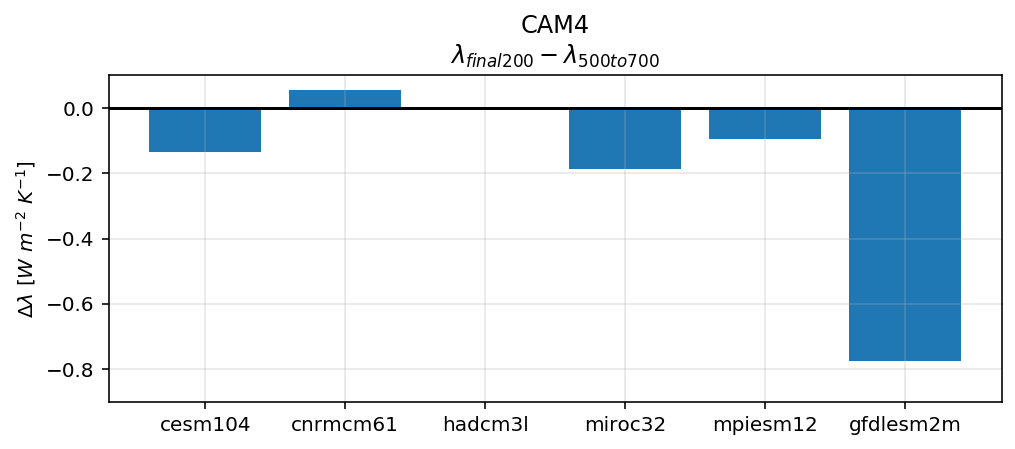

In [204]:
plt.figure(figsize=(8,3),dpi=72*2)
plt.bar(sst_anoms_ds_all_prepped.sst.model.values, ds_500 - ds)
plt.axhline(0,c='k')
plt.ylabel('$\Delta \lambda \ [W \ m^{-2} \ K^{-1}]$')
plt.title('CAM4\n' + 
          '$\lambda_{final200} - \lambda_{500to700}$')
plt.grid(True,alpha=0.3)
plt.ylim(-0.9,0.1)
plt.show()